# Threshold-moving

In our previous notebook "EDA", we have noticed that our data was imbalanced. Our objective will be to correctly classify the minority class of `Fake` actions.

To predict a class label, models use a threshold, such as 0.5, where all values equal or greater than the threshold are mapped to one class and all other values are mapped to another class.

For classification problems that have a severe class imbalance, the default threshold can result in poor performance. As such, a simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold used to map probabilities to class labels.

This notebook tries to look for a tuning mechanism for the optimal threshold.

What we are going to do:
- Load data
- Featurize the data
- Apply different models to see how it goes
- Find threshold that maximizes our prediction

## Load data

In [1]:
import pandas as pd
from IPython.display import display

In [2]:
df = pd.read_csv("../data/fake_users.csv")

df_test = pd.read_csv("../data/fake_users_test.csv")

print(f"Train size: {len(df)}, Test size: {len(df_test)}")
# Unnamed and UserId are dataset artifact, not something useful for analysis
df.drop("Unnamed: 0", axis=1, inplace=True)
df.drop("UserId", axis=1, inplace=True)

df_test.drop("UserId", axis=1, inplace=True)


# A quick reminder of how the data looks like
df.head()

Train size: 100473, Test size: 2998


,Event,Category,Fake
0,click_carrousel,Phone,0
1,send_sms,Motor,0
2,send_email,Jobs,0
3,send_sms,Jobs,0
4,click_ad,Phone,0


## Featurize

Our `Event` and `Category` columns hold nominal categorial data where there are no inherent order (in opposition to ordinal categorial data). These "categories" must be transformed into numbers first, before you can apply the learning algorithm on them.

To achieve that there are different encoding techniques.

- Label Encoding: each label is converted into an integer value based on conversion dictionnary
- One Hot Encoding: each category is mapped with a binary variable containing either 0 or 1. Here, 0 represents the absence, and 1 represents the presence of that category.
- Hash Encoding: each category is encoded using a hash function. It is a good solution when the cardinality of the category is too high.

We will user one hot encoding, because the cardinality of our categories are rather low.


In [3]:
df = pd.get_dummies(df, columns=['Event','Category'], prefix = ['Event', 'Category'])
df_test = pd.get_dummies(df_test, columns=['Event','Category'], prefix = ['Event', 'Category'])

df.head()

,Fake,Event_click_ad,Event_click_carrousel,Event_phone_call,Event_send_email,Event_send_sms,Category_Holidays,Category_Jobs,Category_Leisure,Category_Motor,Category_Phone,Category_Real_State
0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,1,0


In [4]:
from sklearn.model_selection import train_test_split
#X_train, X_validation, y_train, y_validation = train_test_split(df.iloc[:,1:], df["Fake"], test_size=0.2, random_state= 42,stratify=df.Fake)

X_train = df.iloc[:,1:]
y_train = df["Fake"]

X_test = df_test.iloc[:,1:]
y_test = df_test["Fake"]

print(f"Train: X: {X_train.shape}, y {y_train.shape}")
print(f"Test: X: {X_test.shape}, y {y_test.shape}")

Train: X: (100473, 11), y (100473,)
Test: X: (2998, 11), y (2998,)


## Apply different models

Let's see how different models perfom on our data. Because the data is imbalanced we will use a confusion matrix as our metrics. Please see this page for more info about [confusion matrix metrics](https://en.wikipedia.org/wiki/Confusion_matrix).

In [5]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict


def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= confusion_matrix(y, pred, 
            normalize='true')
    print(f"Precision: {precision_score(y, pred):.2f}, Recall: {recall_score(y, pred):.2f}, F1: {f1_score(y, pred):.2f}")


    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0 (Not Fake)', 'True 1 (Fake)'], 
            columns=['Pred 0 (Not Fake)', 
                            'Pred 1 (Fake)'])


'''Test options and evaluation metric'''
def compare_models(X_train, y_train, models, scoring = "f1", num_folds = 5):

    for name, model in models.items():
        kfold = StratifiedKFold(n_splits = num_folds)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=kfold)
        
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring, n_jobs = -1)
        
        models[name] = model
        print(name)
        display(conf_matrix(y_train, y_pred))

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict

'''Test options and evaluation metric'''
def compare_models(X_train, y_train, models, scoring = "f1", num_folds = 5):

    for name, model in models.items():
        kfold = StratifiedKFold(n_splits = num_folds)
        
        y_pred = cross_val_predict(model, X_train, y_train, cv=kfold)
        
        cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring, n_jobs = -1)
        
        models[name] = model
        print(name)
        display(conf_matrix(y_train, y_pred))

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {'DUM' : DummyClassifier(),
          'LR' :LogisticRegression(solver='lbfgs') ,
          'KNN' : KNeighborsClassifier(),
          'DT': DecisionTreeClassifier(),
         }

compare_models(X_train, y_train, models)

DUM
Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/tekeinhor/opt/miniconda3/envs/ntb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Pred 0 (Not Fake),Pred 1 (Fake)
True 0 (Not Fake),TN = 90114 (TNR = 100.00%),FP = 0 (FPR = 0.00%)
True 1 (Fake),FN = 10359 (FNR = 100.00%),TP = 0 (TPR = 0.00%)


LR
Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/tekeinhor/opt/miniconda3/envs/ntb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Pred 0 (Not Fake),Pred 1 (Fake)
True 0 (Not Fake),TN = 90114 (TNR = 100.00%),FP = 0 (FPR = 0.00%)
True 1 (Fake),FN = 10359 (FNR = 100.00%),TP = 0 (TPR = 0.00%)


KNN
Precision: 0.18, Recall: 0.16, F1: 0.17


,Pred 0 (Not Fake),Pred 1 (Fake)
True 0 (Not Fake),TN = 82829 (TNR = 91.92%),FP = 7285 (FPR = 8.08%)
True 1 (Fake),FN = 8709 (FNR = 84.07%),TP = 1650 (TPR = 15.93%)


DT
Precision: 0.00, Recall: 0.00, F1: 0.00


/Users/tekeinhor/opt/miniconda3/envs/ntb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Pred 0 (Not Fake),Pred 1 (Fake)
True 0 (Not Fake),TN = 90114 (TNR = 100.00%),FP = 0 (FPR = 0.00%)
True 1 (Fake),FN = 10359 (FNR = 100.00%),TP = 0 (TPR = 0.00%)


## Selecting KNN and rock with it

Our cross-validation indicates that a KNN (k-nearest neighbors classifier) perfoms a little bit better than the others. So let's choose it as a base classifier.

In [7]:
from sklearn.model_selection import GridSearchCV

knears_params = {"n_neighbors": [2, 3, 4, 5], 'algorithm': ['auto', 'ball_tree', 'kd_tree'], "weights": ['uniform', 'distance']}
model =  KNeighborsClassifier()

grid_search = GridSearchCV(estimator = model, param_grid = knears_params, cv = 5, verbose = 1,
                         scoring = "f1", n_jobs = -1)
grid_search.fit(X_train, y_train)
print(f"KNN best params:{grid_search.best_params_} & best_score:{grid_search.best_score_:0.3f} / {grid_search.best_estimator_}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
KNN best params:{'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'} & best_score:0.199 / KNeighborsClassifier(n_neighbors=3)


## Threshold moving

Now let's think about threshold. Let us adjust the threshold for which we decide “Fake” label should be applied label, given a predicted probability. By default, this threshold is `0.5`. Beforehands, let's train a KNN with the best estimators of our gridsearch.

In [8]:
model =  KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [9]:
y_pred=model.predict(X_test)
conf_matrix(y_test,y_pred)

Precision: 0.29, Recall: 0.17, F1: 0.21


,Pred 0 (Not Fake),Pred 1 (Fake)
True 0 (Not Fake),TN = 2418 (TNR = 93.61%),FP = 165 (FPR = 6.39%)
True 1 (Fake),FN = 346 (FNR = 83.37%),TP = 69 (TPR = 16.63%)


We want to improve the Recall of class 1 (the TPR) to reduce our bot threat (reduce false negatives).

To do this, we can reduce the threshold for which we label “Class 1” (`Fake`) when we predict a probability above the threshold. This way we say “Class 1” (`Fake`) for a wider range of predicted probabilities. Such strategies are known as threshold-moving.

Now let's try to selection our threshold in order to maximise our f1-score (to have a balance between precision and recall)

In [12]:
from numpy import argmax
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds_ = precision_recall_curve(y_test, y_pred)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds_[ix], fscore[ix]))

Best Threshold=0.000000, F-Score=0.243


With that `Threshold=0.333333`, our confusion matrix looks like below.

In [16]:
import numpy as np
y_tuned_thresh = np.where(y_pred >= 0.2, 1, 0)
conf_matrix(y_test, y_tuned_thresh)

Precision: 0.29, Recall: 0.17, F1: 0.21


,Pred 0 (Not Fake),Pred 1 (Fake)
True 0 (Not Fake),TN = 2418 (TNR = 93.61%),FP = 165 (FPR = 6.39%)
True 1 (Fake),FN = 346 (FNR = 83.37%),TP = 69 (TPR = 16.63%)


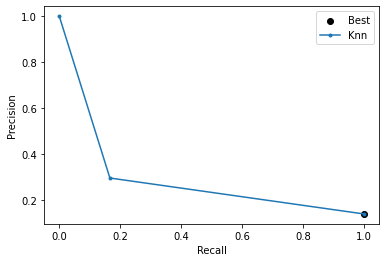

In [14]:
from matplotlib import pyplot
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
pyplot.plot(recall, precision, marker='.', label='Knn')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

However we need to find a balance since the number of False Positives (true legitimate events rejected as Fake) inevitably increases as we adjust the threshold that we apply to the model’s probability prediction.

It is worth noting that, even though I have chosen a threshold, ultimately it depends solely on the cost to the business of false negatives vs. false positives.